# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import inflection
import math
import random
import warnings
import pickle

from matplotlib import pyplot as plt
from scipy import stats as ss
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

from IPython.core.display import HTML
from IPython.display import Image

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    #cm -> Confusion Matrix, que irá efetuar através da tabela de contingência a contagem do cruzamento de ocorrência entre variaveis categoricas
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error(y , yhat):
    return np.mean(np.abs((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose = False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range (1, kfold+1)):
        if verbose:
            print('\nKFold nº: {}'.format(k))
        #start and end day for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
    
        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #Training and Validation dataset
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)   

        #analysis
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        #store each performance of kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name' : model_name,
                          'MAE_CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                          'MAPE_CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str), 
                          'RMSE_CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/valquiriaam/.pyenv/versions/3.8.0/envs/DS_producao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv( 'datasets/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'datasets/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [12]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [14]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


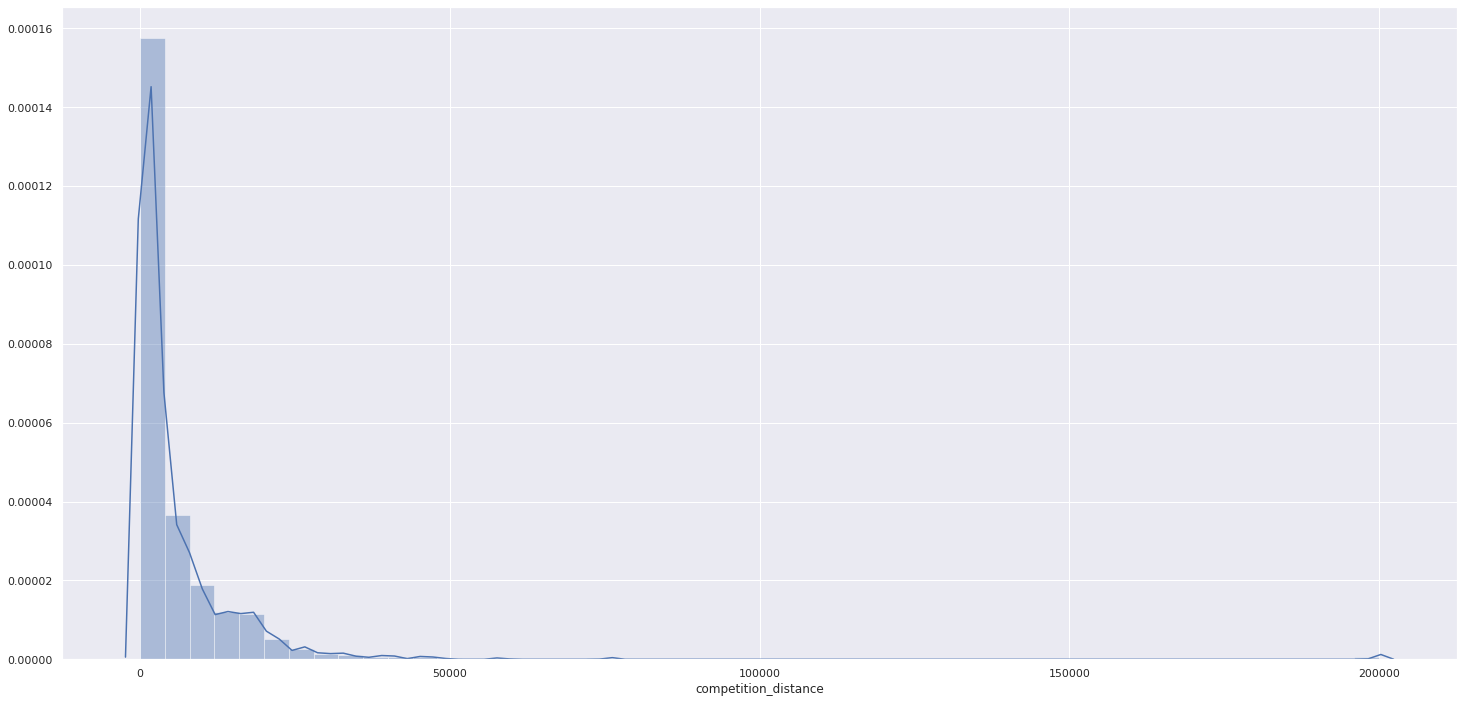

In [15]:
sns.distplot( df1['competition_distance']);

### 1.7.2. Categorical Atributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

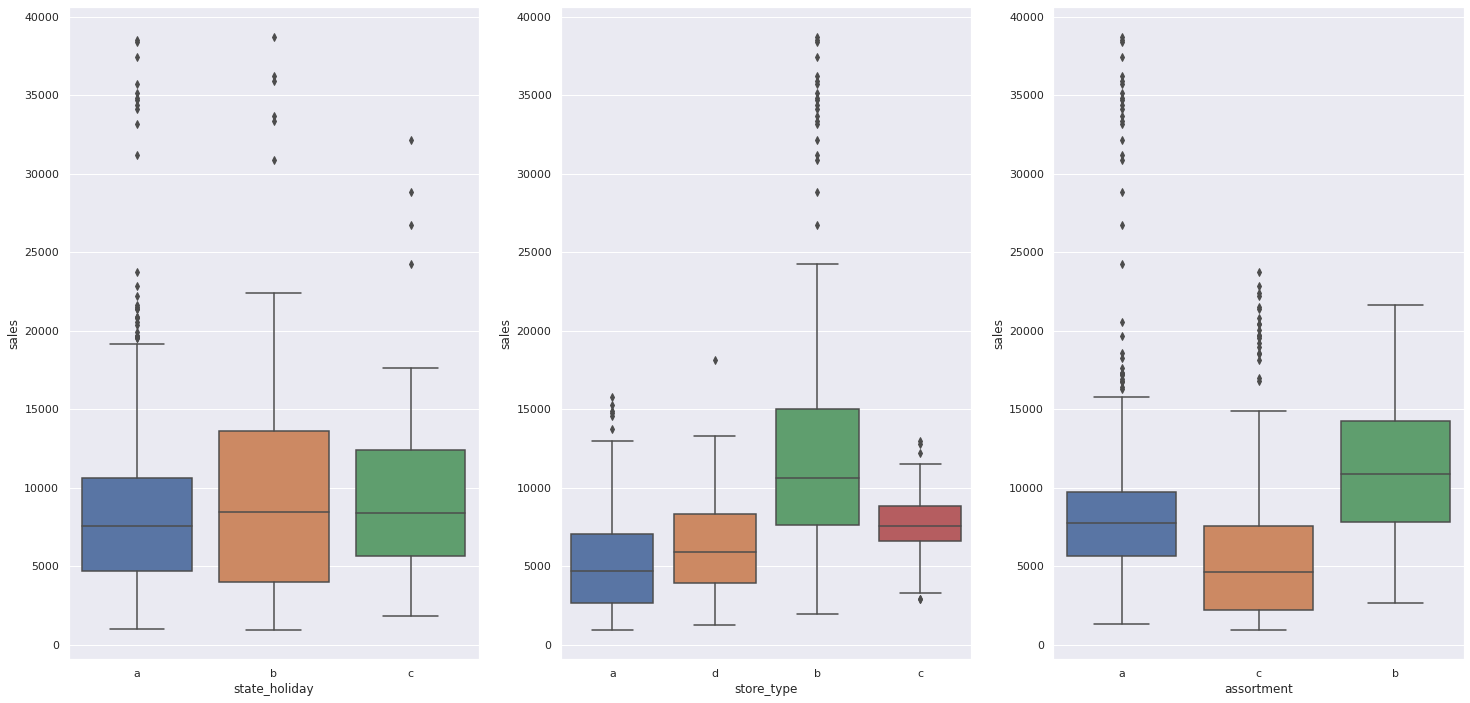

In [17]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 );


# 2.0. PASSO 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

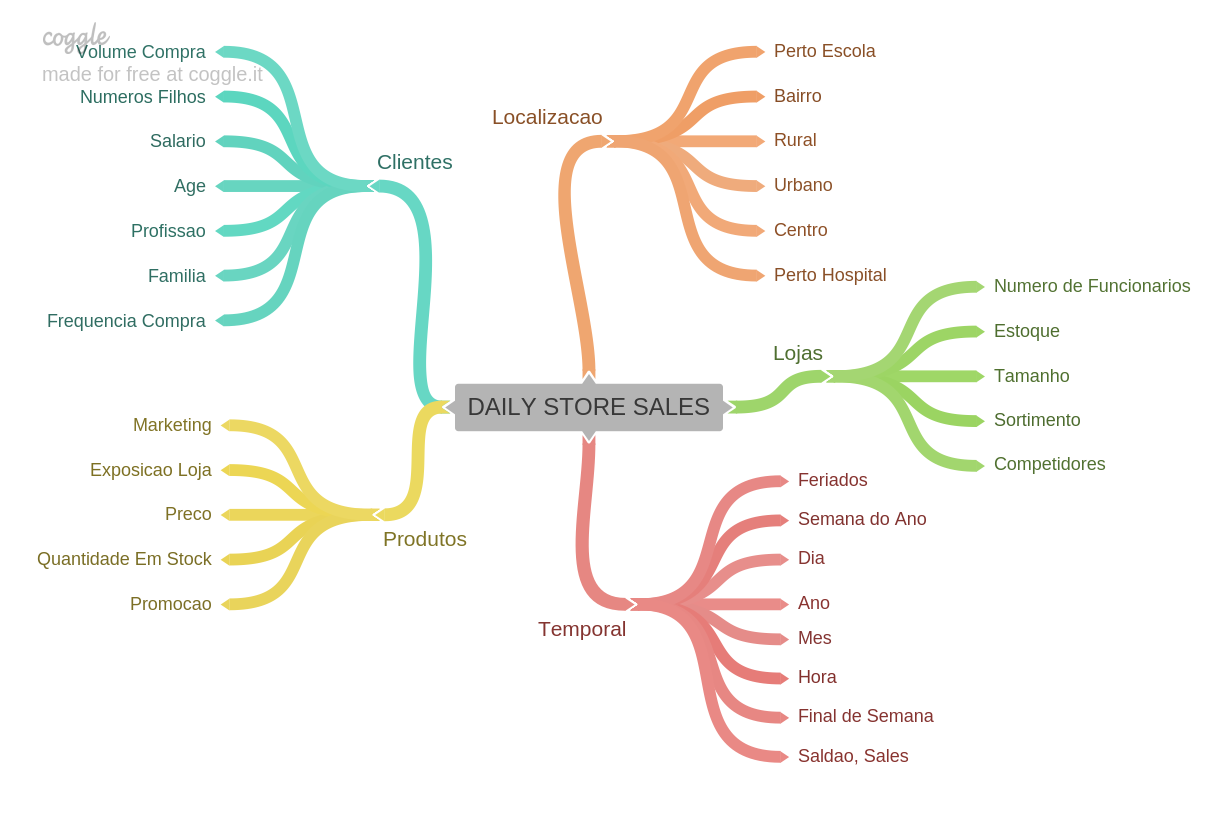

In [19]:
Image('img/MindMapHypothesis.png')

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

<ipython-input-20-f9f7d9cdca20>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 FILTRAGEM DE VÁRIAVEIS

In [21]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas


In [22]:
# atributo 'open' -> Não há ganho de informação(aprendizado) em linhas onde open = 0
# atributo 'sales' -> Deverá ser maior que 0

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]


## 3.2 Filtragem de Colunas


In [23]:
# atributo 'customers' -> Não disponível no momento da predição
# atributos 'promo_interval' e 'month_map' -> Não são mais necessários, pois já foram derivadas features dessas colunas

cols_drop = ['open', 'customers', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [24]:
df4 = df3.copy()

## 4.1 Análise Univariada


### 4.1.1 Response Variable


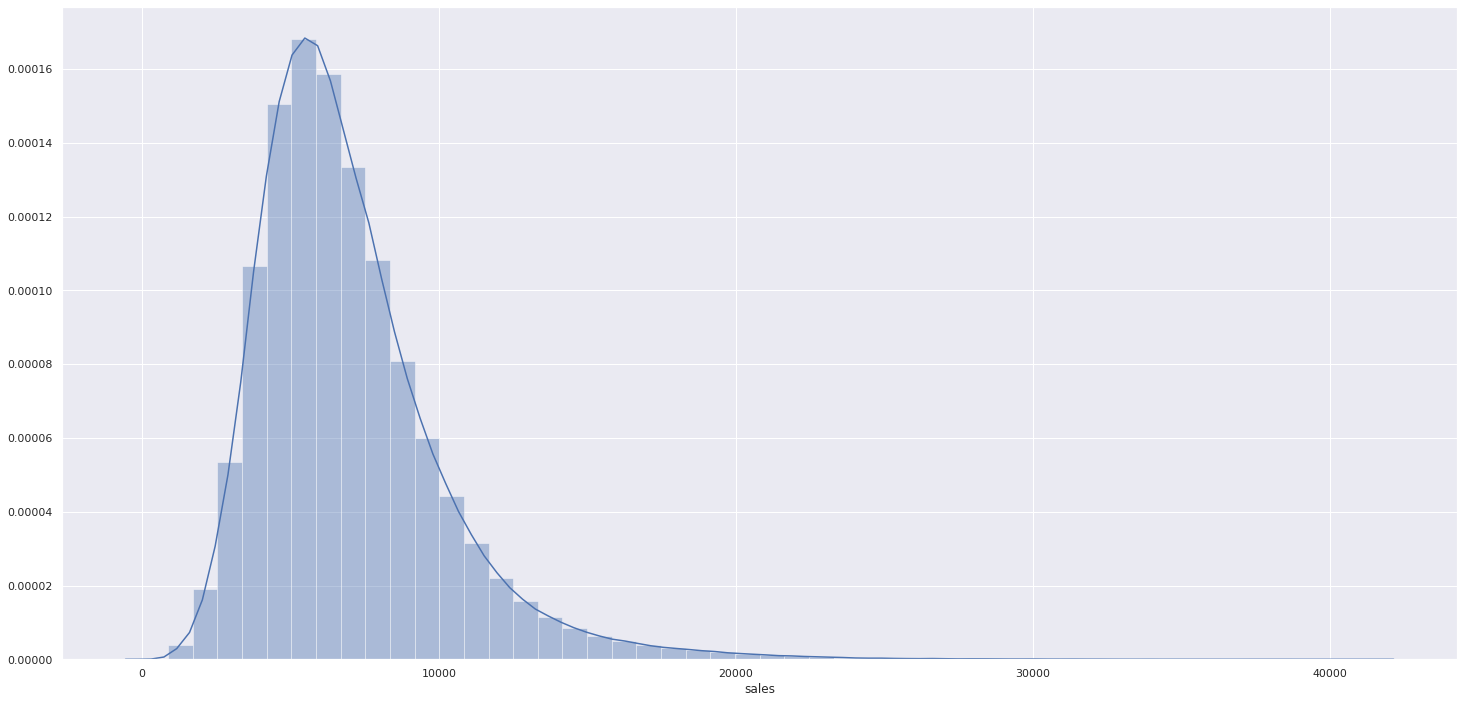

In [25]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical Variable


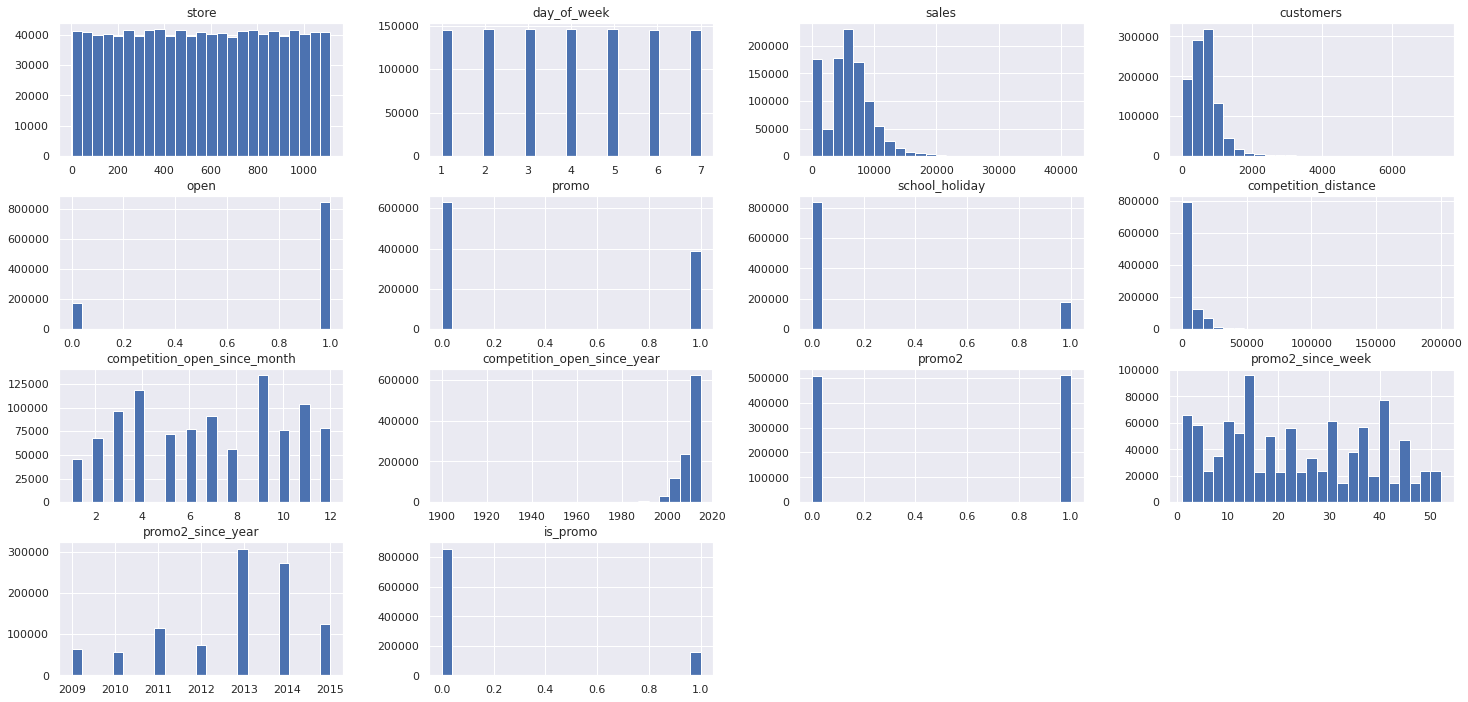

In [26]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable


In [27]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [28]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [29]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: >

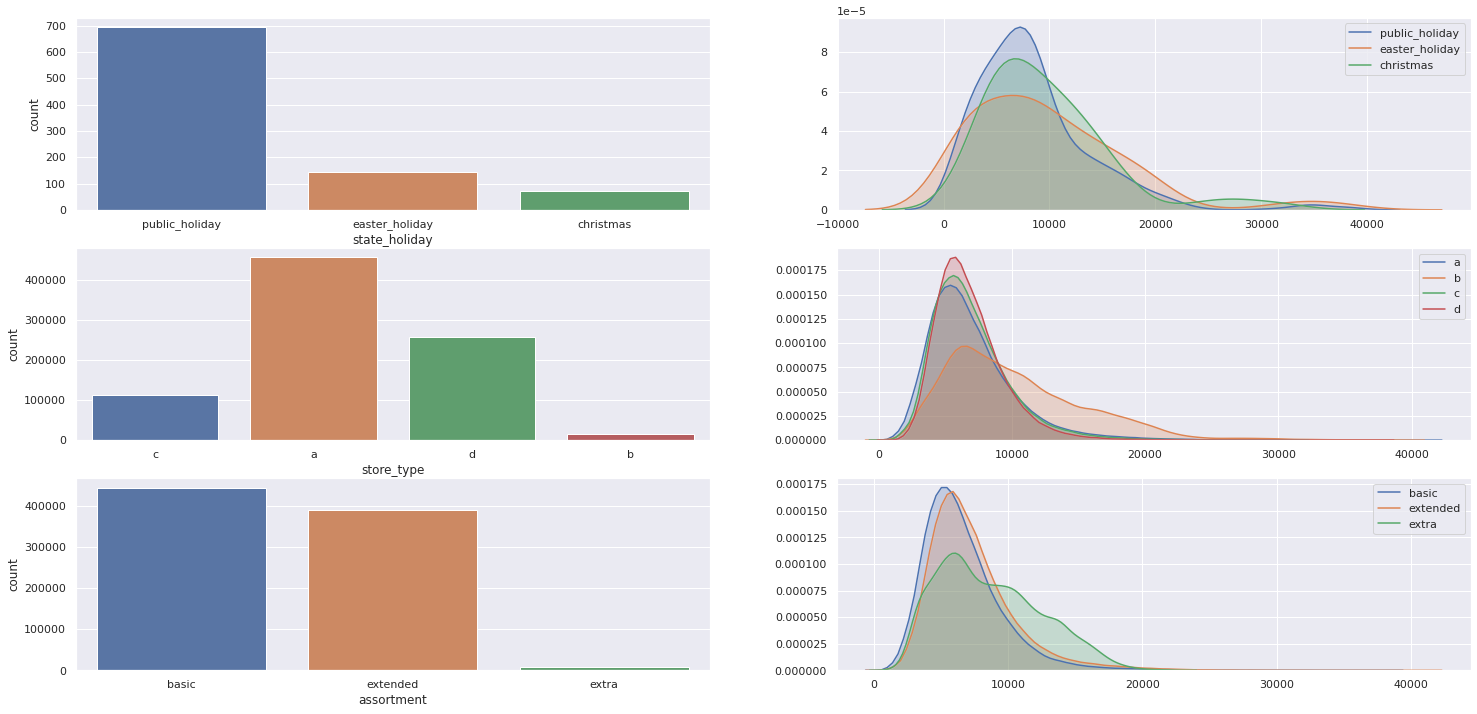

In [30]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Análise Bivariada


### **H1**.Lojas com maior sortimento deveriam vender mais.
***FALSE*** -> Lojas com maior sortimento vendem menos!


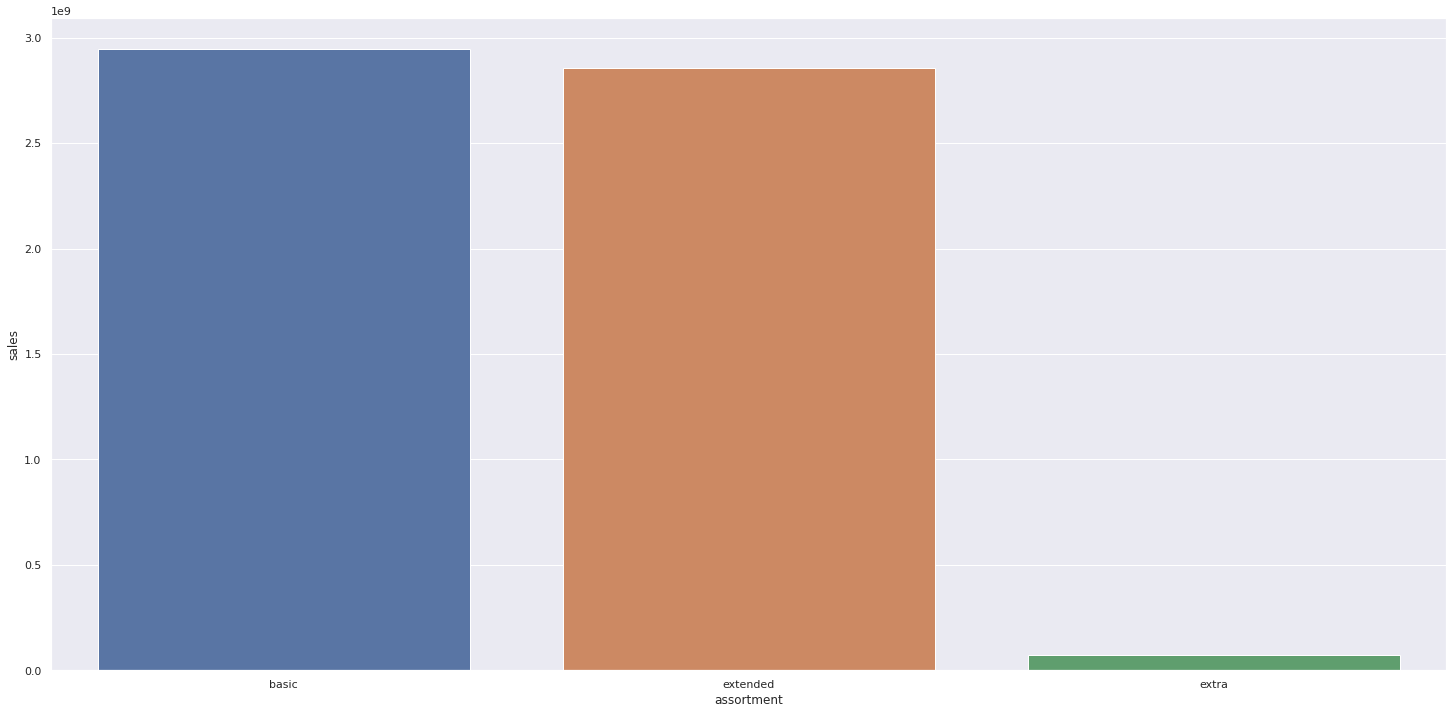

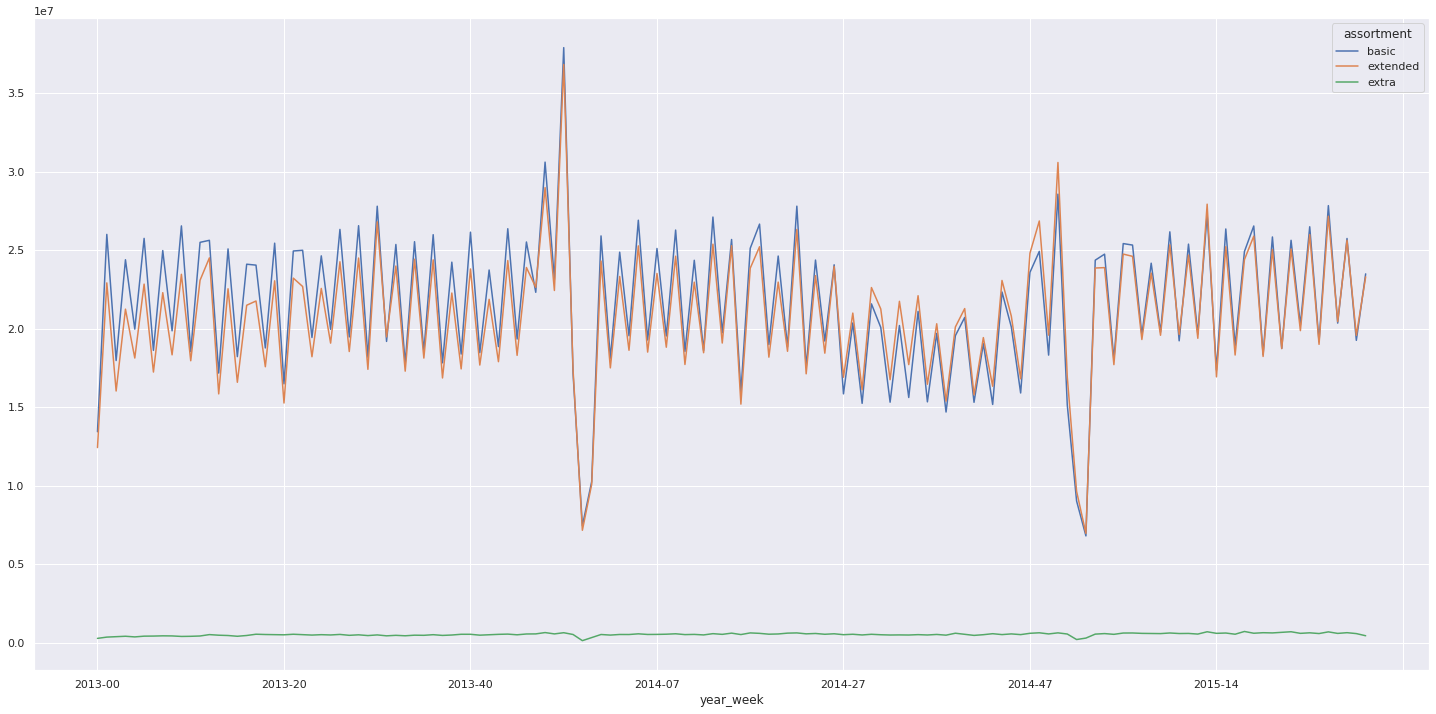

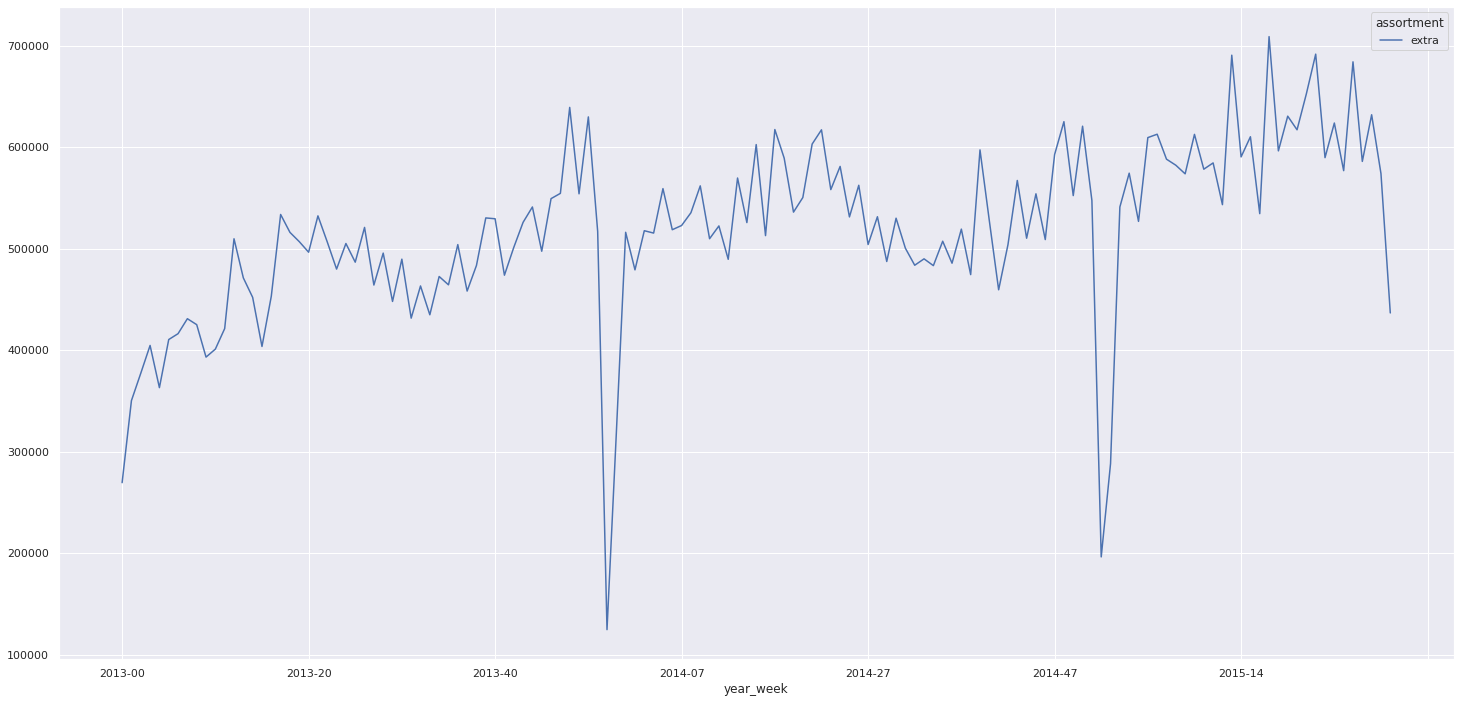

In [31]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales');

#análise de mudança ao longo do tempo para os tipos de loja
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index= 'year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot();


## **H2.** Lojas com competidores mais próximos deveriam vender menos.
***FALSE*** -> Lojas com Competidores mais próximos vendem mais


<ipython-input-32-56547ecbd0c1>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method='pearson') , annot=True);


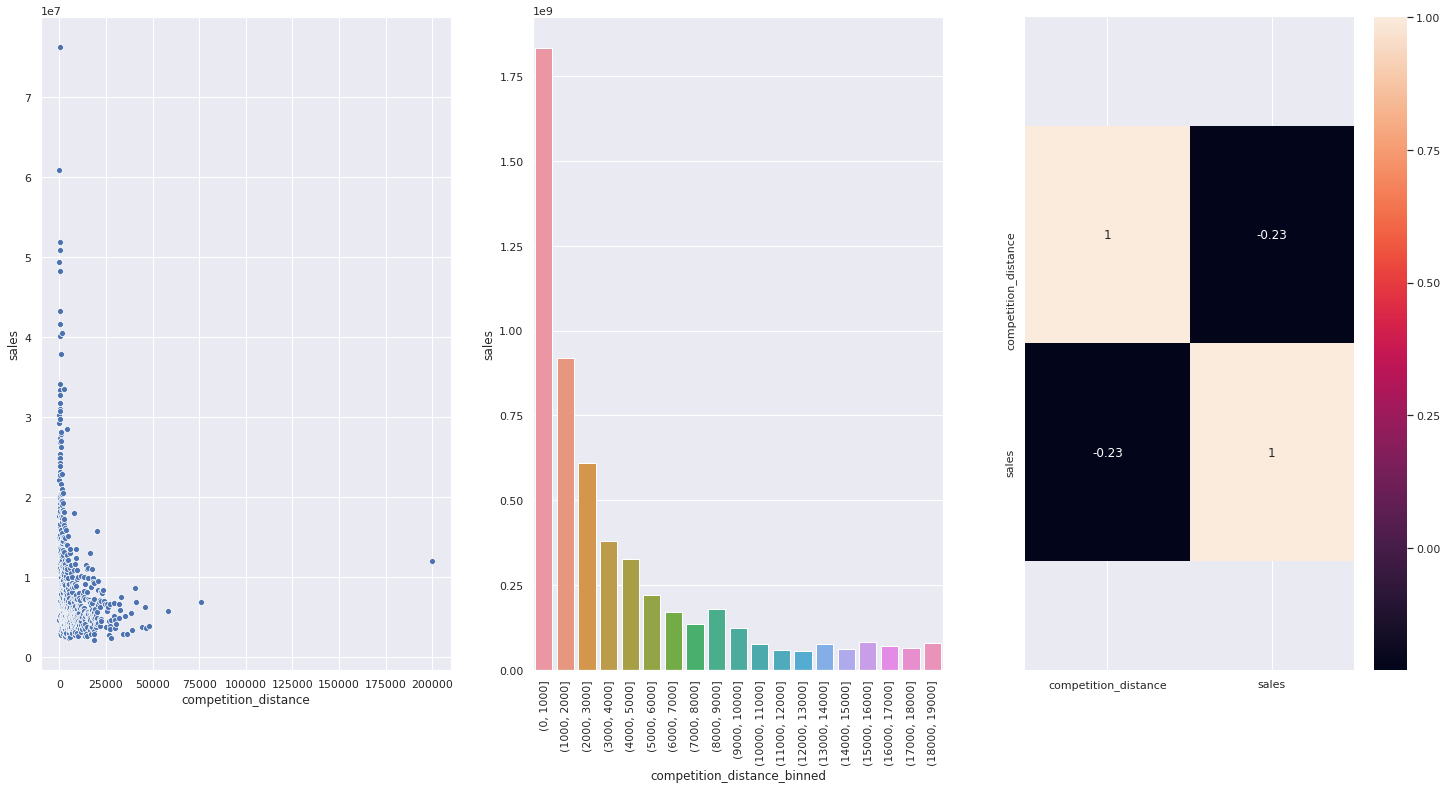

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot (1, 3, 1)
sns.scatterplot(data=aux1, x='competition_distance', y='sales')

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales');
plt.xticks(rotation=90);

plt.subplot (1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson') , annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);


## **H3.** Lojas com competidores a mais tempo deveriam vender mais.


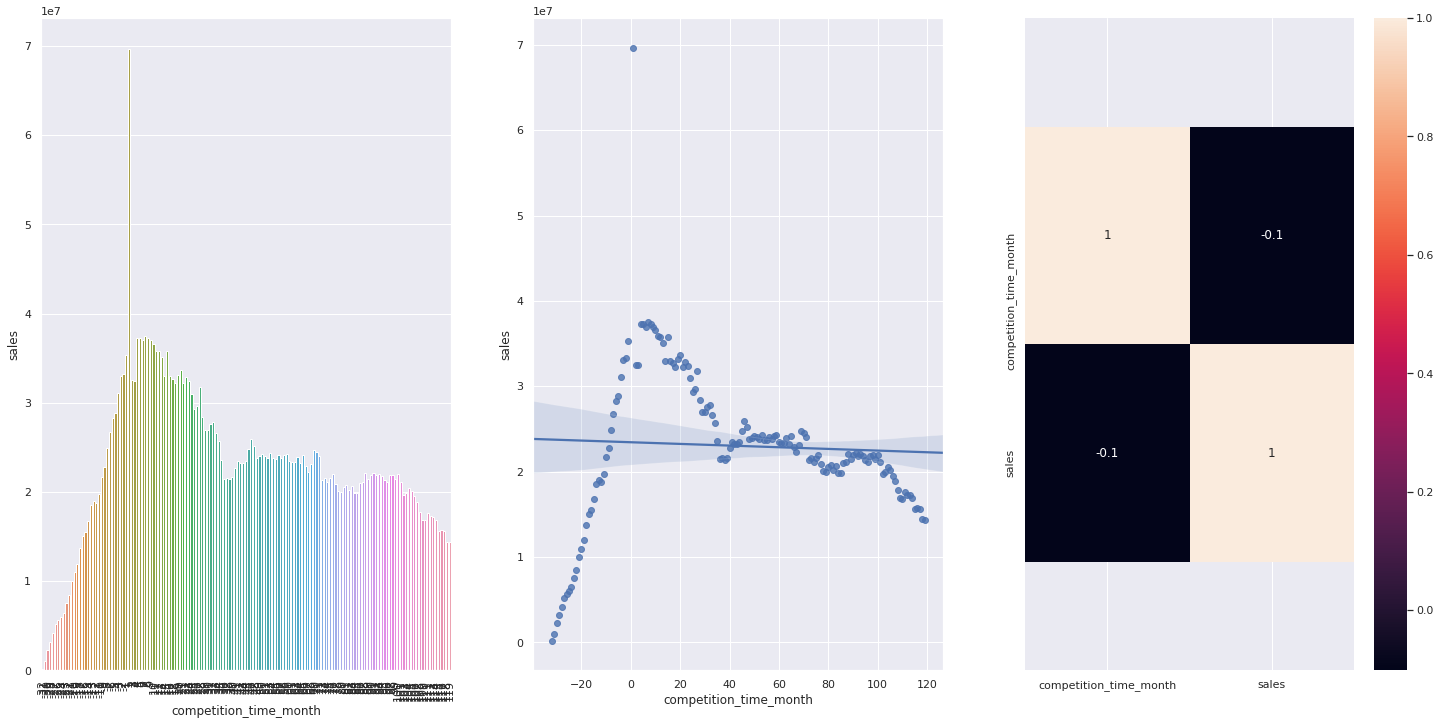

In [33]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);


### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA*** -> lojas com promoções ativas por mais tempo vendem MENOS depois de um certo período de promoção


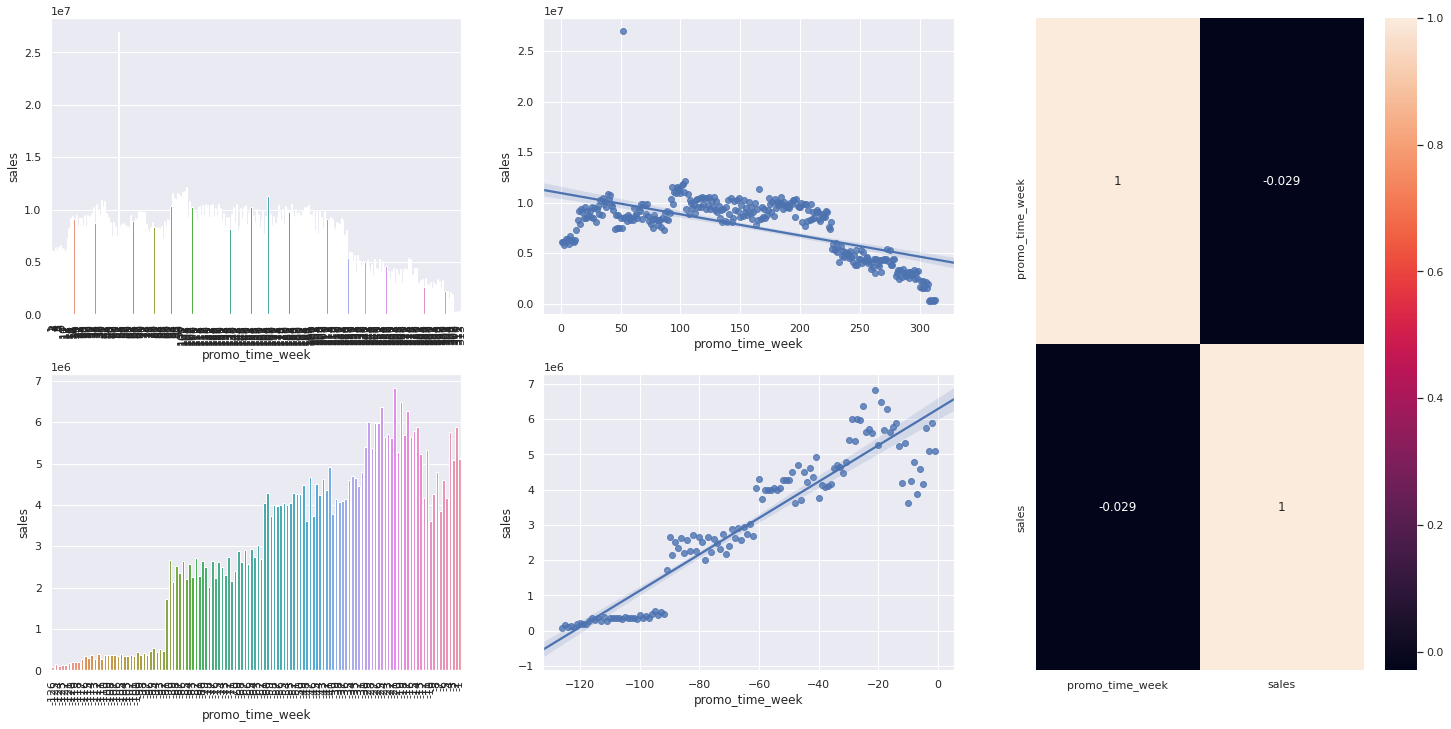

In [34]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90)

plt.subplot(grid [0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales')

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(data=aux3, x='promo_time_week', y='sales')
plt.xticks(rotation=90)

plt.subplot(grid [1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales')

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>
***Hipótese recorrente de H4 -> Caso necessário, no segundo ciclo CRISP, fazer a contagem de tempo de promoção pelos DIAS***


### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
***Falsa*** -> Lojas com mais promoções consecutivas vendem MENOS.


In [35]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


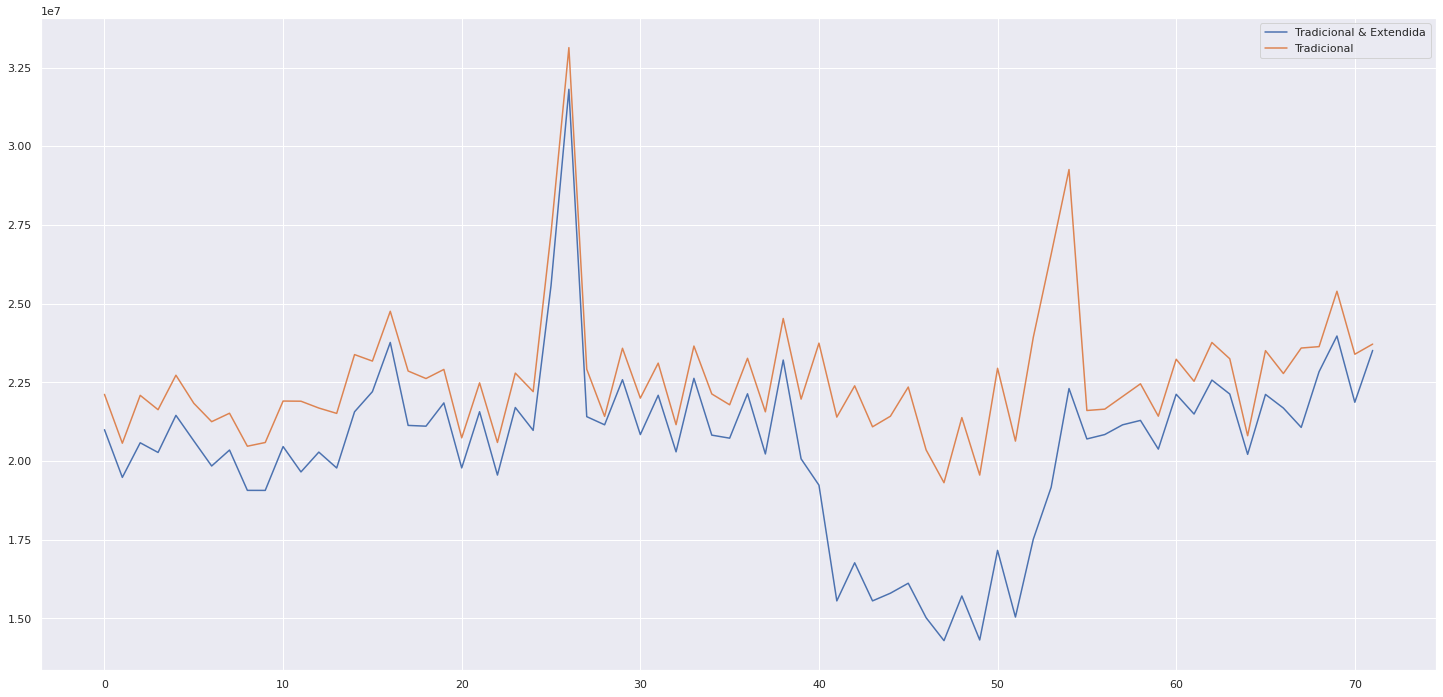

In [36]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax )

ax.legend( labels = ['Tradicional & Extendida', 'Tradicional']);


### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
***Falsa*** -> Lojas abertas durante o feriado do natal vendem MENOS


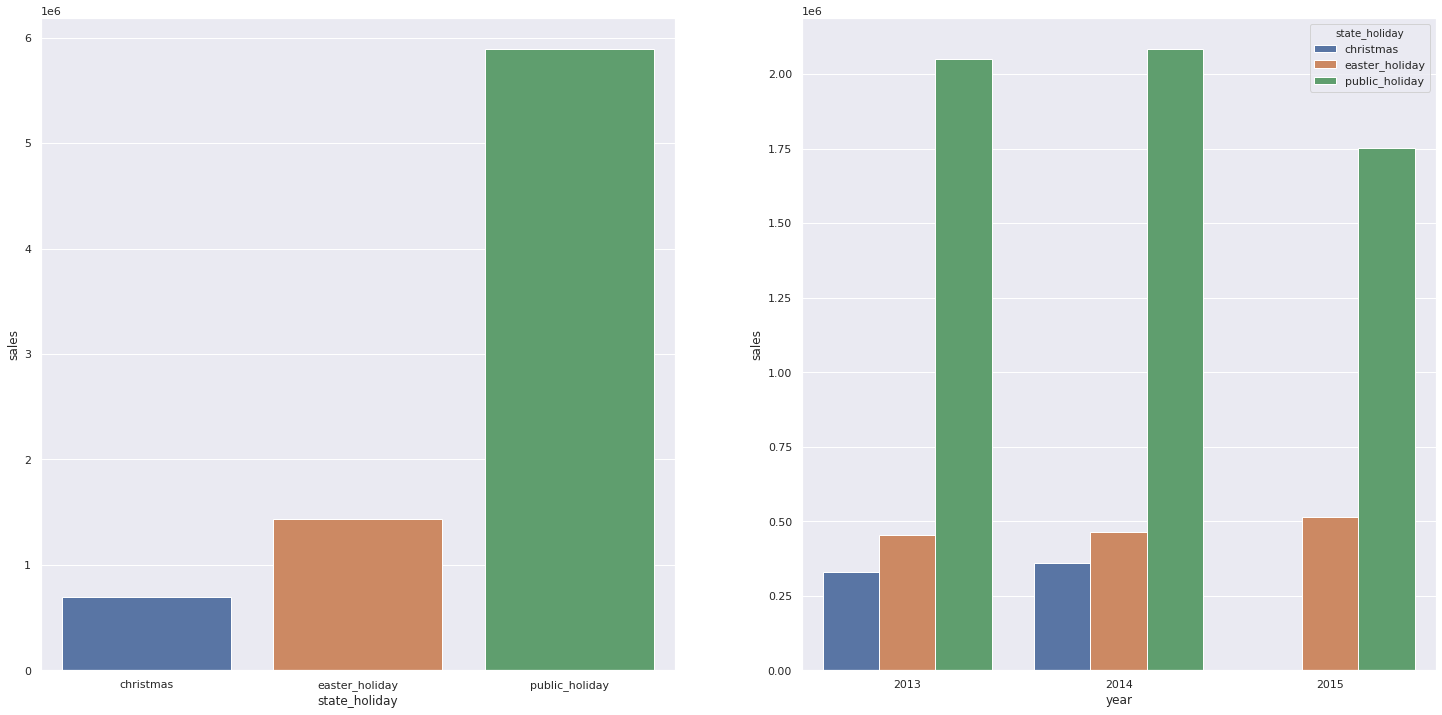

In [37]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot (1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( data=aux1, x='state_holiday', y='sales');

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( data=aux2, x='year', y='sales', hue='state_holiday');


### **H8.** Lojas deveriam vender mais ao longo dos anos.
***Falsa*** -> Lojas vendem MENOS ao longo dos anos (apresentam tendência de queda nas vendas)


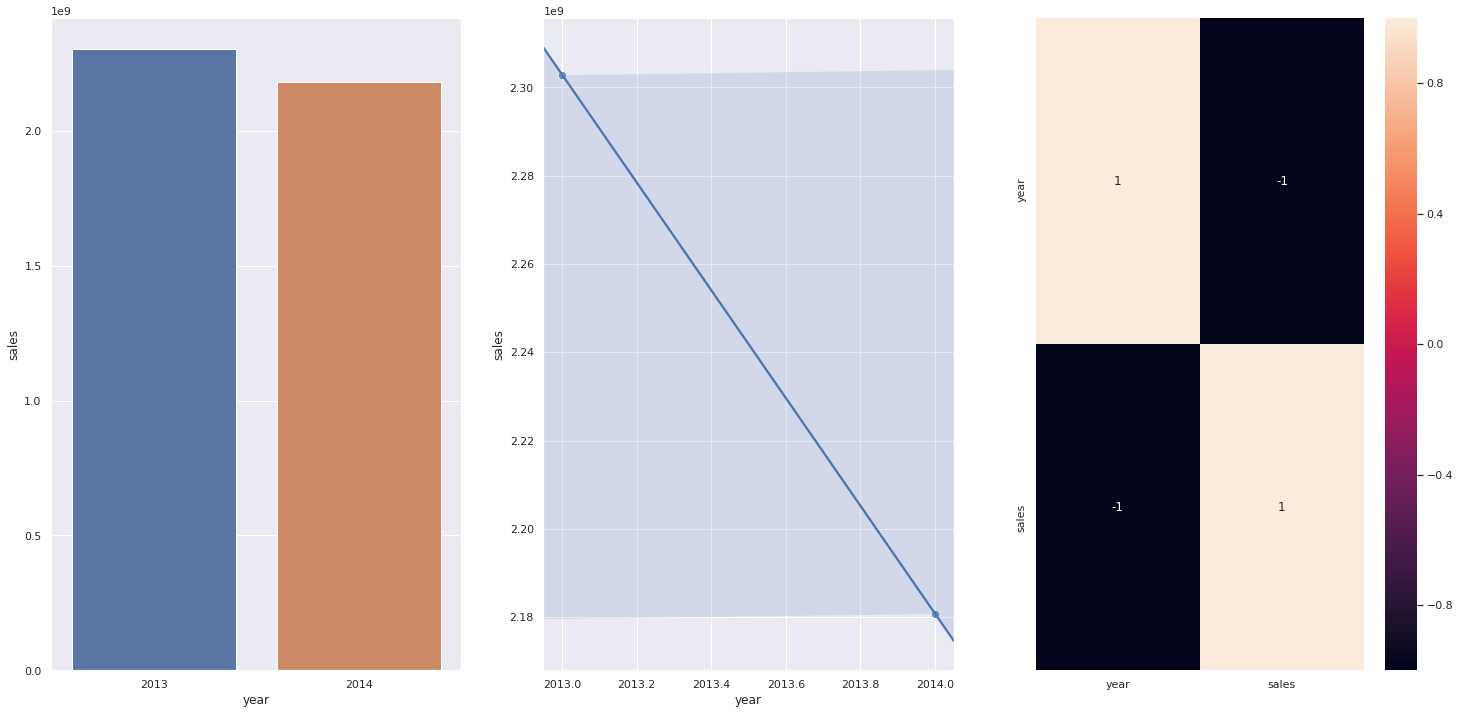

In [38]:
aux = df4[df4['year'] < 2015]
aux1 = aux[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='year', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='year', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
***Falsa*** -> Lojas vendem MENOS no segundo semestre do ano


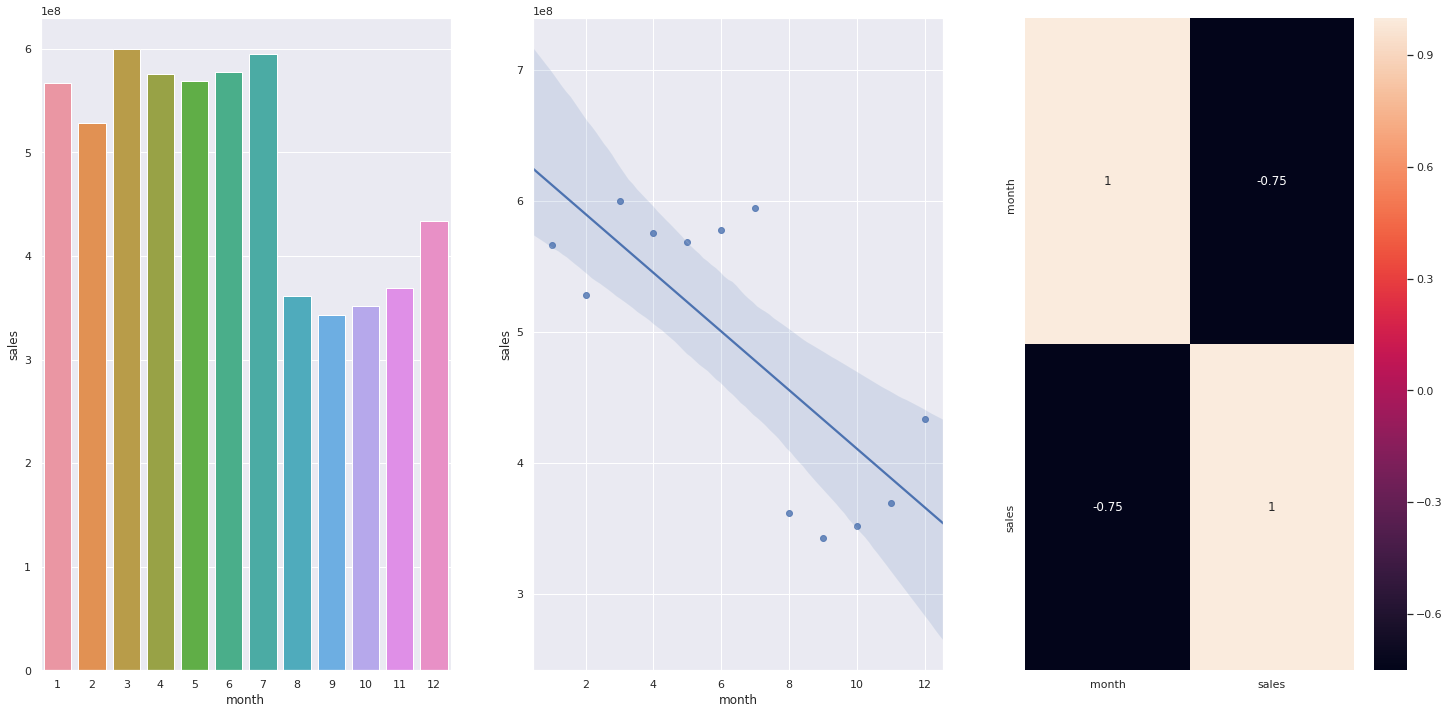

In [39]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='month', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
***Verdadeira***


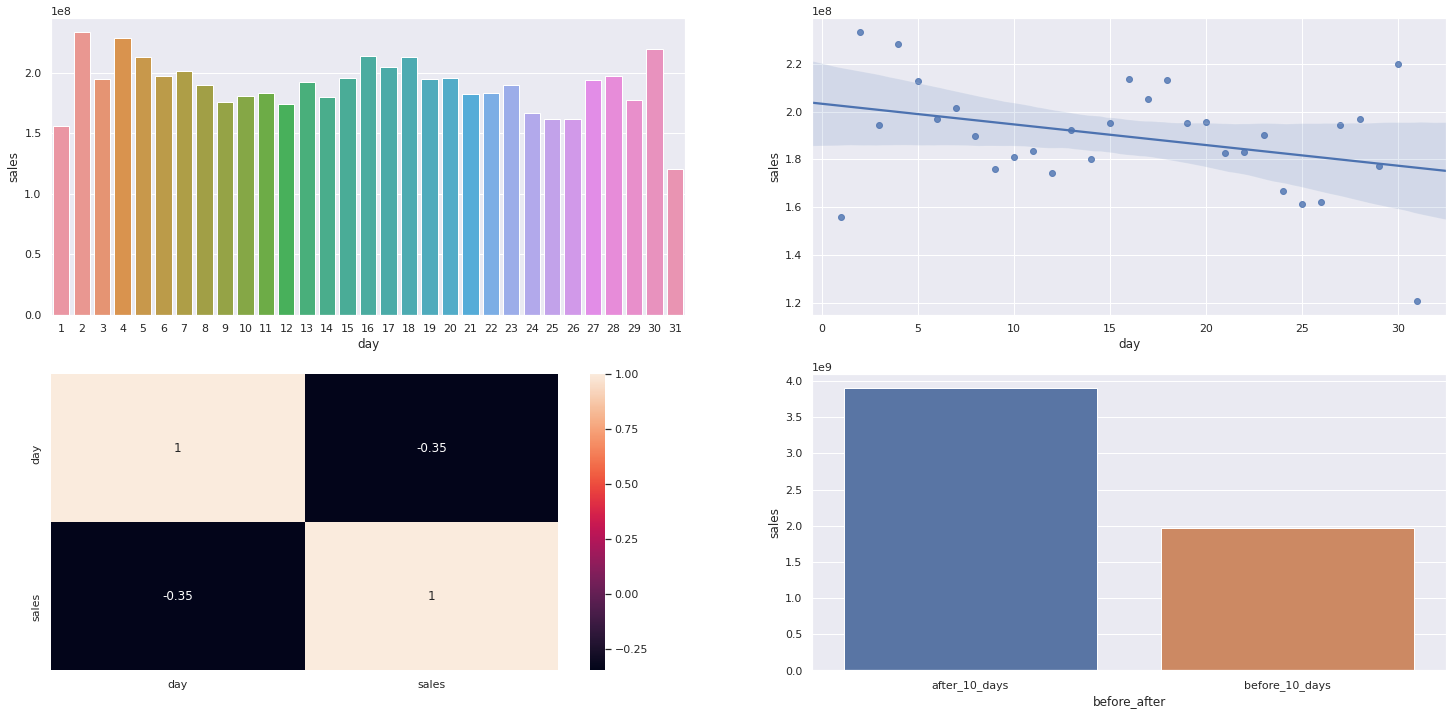

In [40]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,2)
sns.regplot(data=aux1, x='day', y='sales');

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(data=aux2, x='before_after', y='sales');


### **H11.** Lojas deveriam vender menos aos finais de semana.
***Verdadeira*** (Correlação Negativa ao longo dos dias da semana)


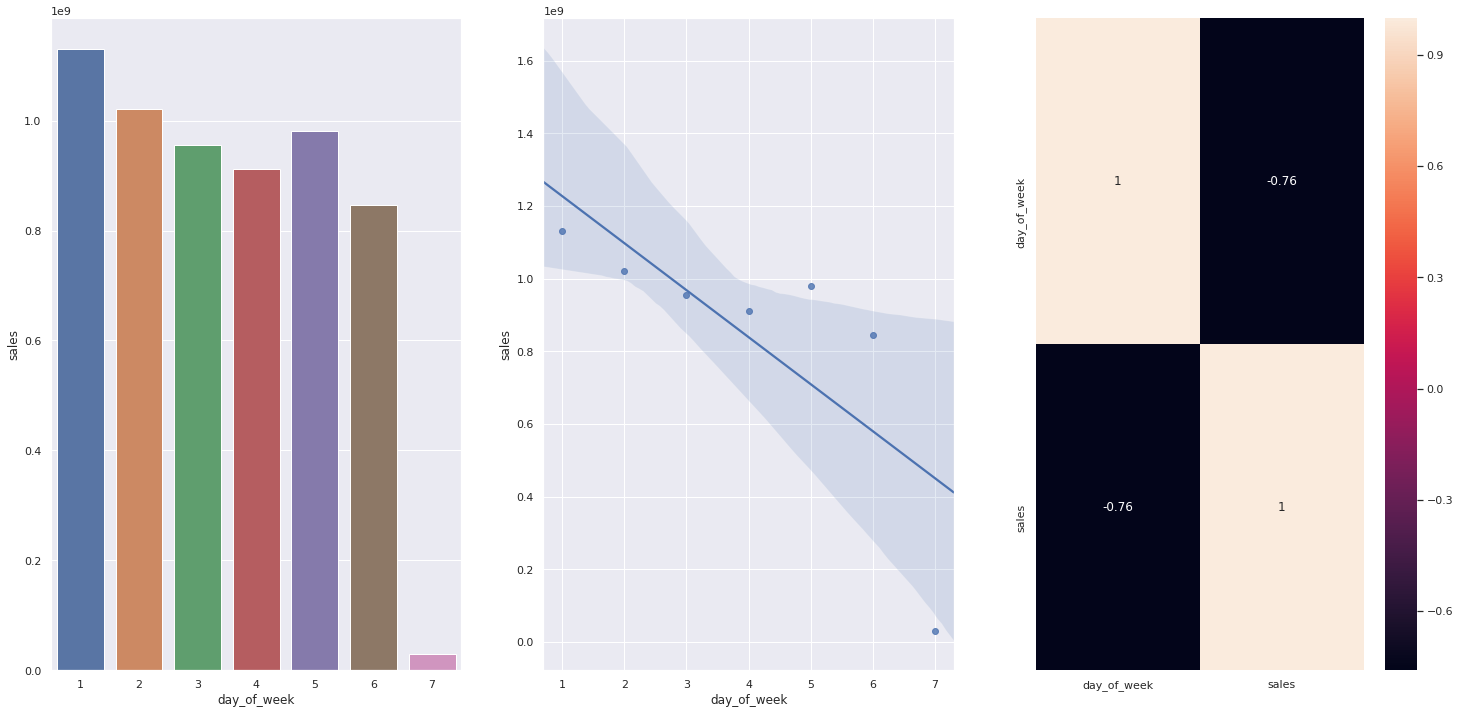

In [41]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,2)
sns.regplot(data=aux1, x='day_of_week', y='sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H12.** Lojas deveriam vender menos durante os feriados escolares.


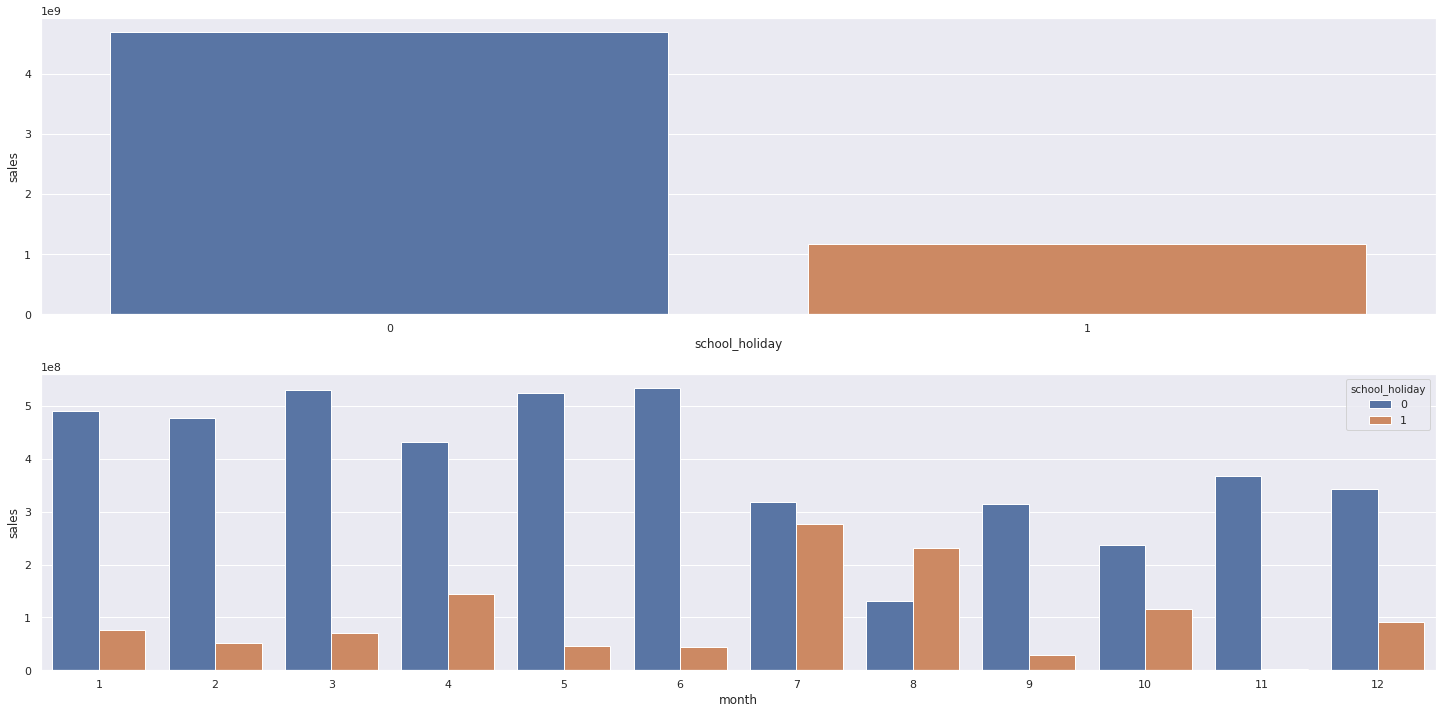

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(data = aux1, x='school_holiday', y='sales');

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday');


### 4.2.1 Resumo das Hipóteses

In [43]:
from tabulate import tabulate


In [44]:
tab = [[ 'Hipóteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'], #Apenas um periodo especifico de tempo apresenta variabilidade entre o compartamento das variaveis em análise
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'], #Não é um Insight; revela apenas um problema: a queda no número geral de vendas.
      ['H9', 'Falsa', 'Alta'], #Não é insight; revela apenas uma característica do negócio -> A de vender mais no primeiro semestre.
      ['H10', 'Verdadeira', 'Alta'], #Não é insight; idem H9
      ['H11', 'Verdadeira', 'Alta'], #Não é insight
      ['H12', 'Verdadeira', 'aixa']]

#A relevância de cada hipótese é marcada pela intensidade com a qual uma váriavel impacta na outra; observada principalmente pelos gráficos de heatmap com coef de correlação.
#As hipóteses que não configuram insight podem ter relevância para aplicação de um modelo de ML.

print(tabulate(tab, headers='firstrow'))



Hipóteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   aixa


## 4.3 Análise Multivariada
    - Consiste em verificar a dependencia entre os vetores (colunas de um dataset), de forma a possibilitar a diminuição da complexidade de um dataset através da remoção de colunas sem perda de informação, tornando assim o dataset mais leve  objetivando melhor performance dos algoritmos de ML.
    

### 4.3.1 Numerical Attributes


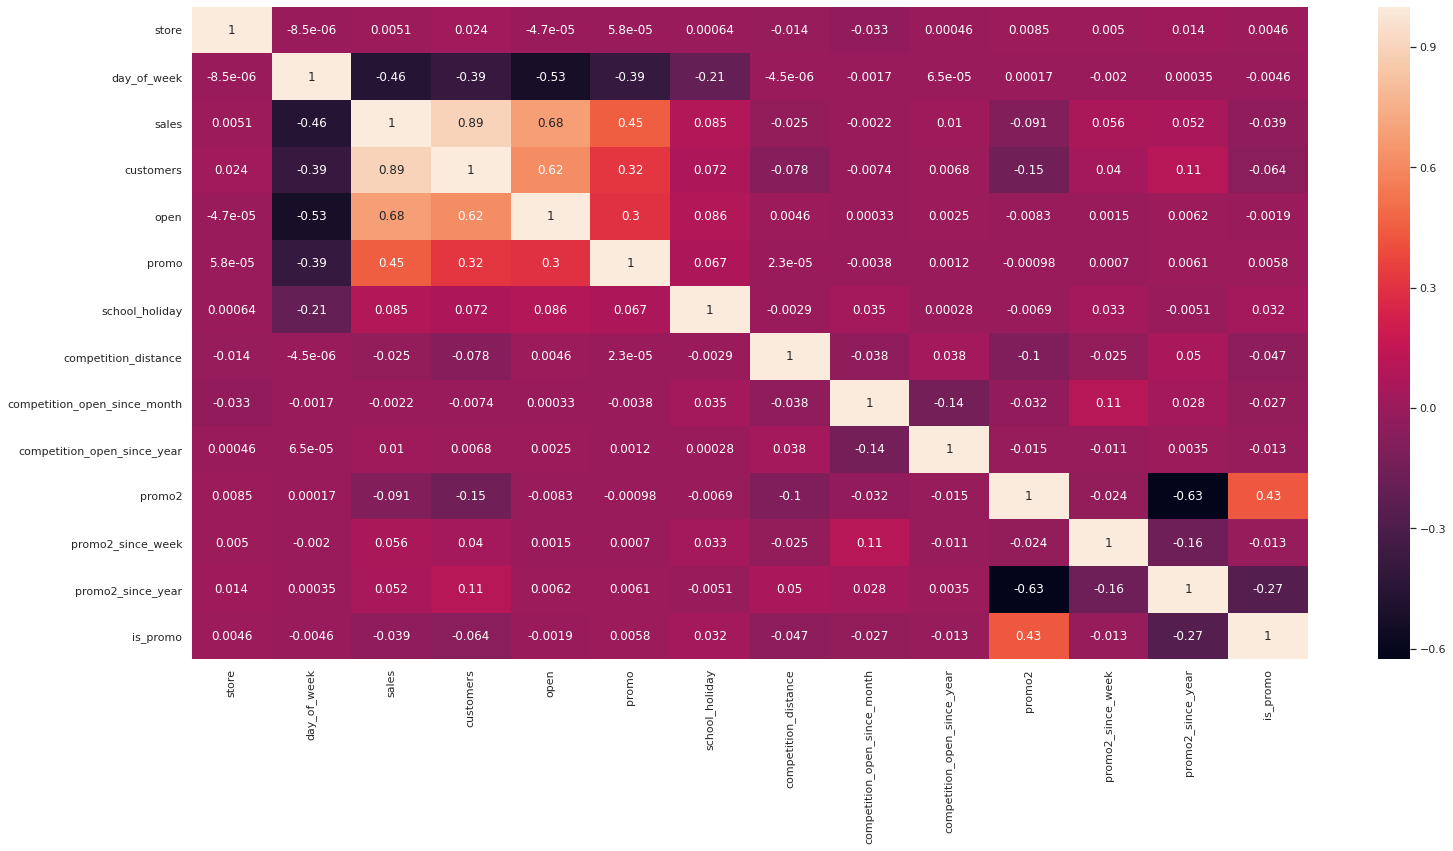

In [45]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);


### 4.3.2 Categorical Attributes


In [46]:
a = df4.select_dtypes( include = 'object' )


In [47]:
def cramer_v(x, y):
    #cm -> Confusion Matrix, que irá efetuar através da tabela de contingência a contagem do cruzamento de ocorrência entre variaveis categoricas
    cm = pd.crosstab( x,y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min ( kcorr-1, rcorr-1)) )


In [48]:
cramer_v (a['state_holiday'], a['store_type'])

0.07106469715258833

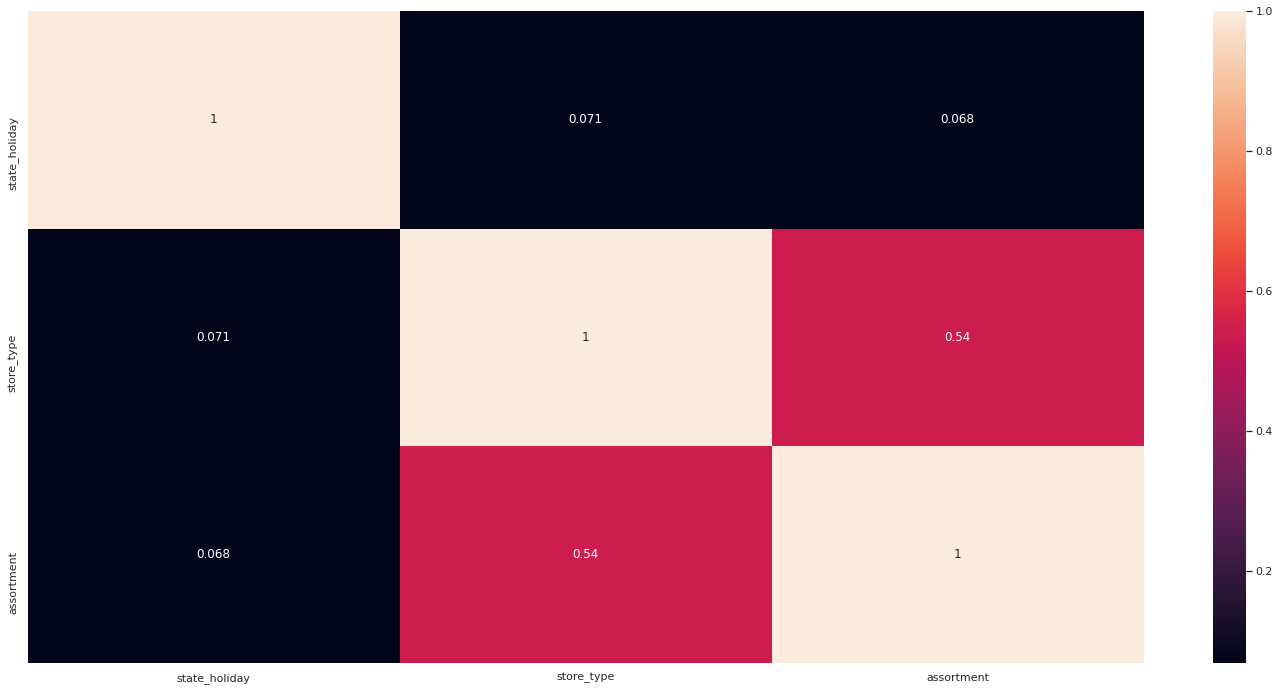

In [49]:
#Heatmap Cramer_V
a.head()

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({ 'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})
d = d.set_index( d.columns )

sns.heatmap(d, annot=True);



# 5.0 DATA PREPARATION

In [50]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Reescaling

In [51]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [52]:
#Analisa-se a ocorrência de outliers para a aplicação do método de reescalonamento

rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformacao

In [53]:
b = df5.select_dtypes(include = ['object'])

In [54]:
#Análise de variáveis categóricas

#state_holiday - one-hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns= ['state_holiday'])

#store_type (Label Encoding)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5[['store_type']])

#assortment (Ordinal Encoding)
assortment_dict = {'basic' : 1,
                   'extra' : 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


/home/valquiriaam/.pyenv/versions/3.8.0/envs/DS_producao/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
#As váriaveis que apresentam caráter ciclico aplica-se outra forma de encoding. Usou-se a transformação sin-cos para manter essa natureza em análise

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))


In [56]:
df5['sales'] = np.log1p(df5['sales'])

# 6.0 FEATURE SELECTION


In [57]:
df6 = df5.copy()

## 6.1 Train-Test Split

In [58]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [59]:
cols_drop = ['day_of_week', 'week_of_year', 'day', 'month', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [60]:
#Uma vez que esse modelo é dependente da aprendizagem das vendas em relação ao tempo, o treinamento do algoritmo não foi feito por amostragem aleatório; usou-se as 6 semanas mais recentes para teste, e o restante para treino de previsão das vendas

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)


Timestamp('2015-06-19 00:00:00')

In [61]:
#Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min date: {}'.format(X_train['date'].min()))
print('Training Max date: {}'.format(X_train['date'].max()))

print('\nTest Min date: {}'.format(X_test['date'].min()))
print('Test Min date: {}'.format(X_test['date'].max()))


Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Min date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selection

In [62]:
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()  #método ravel retorna os valores em vetor
#
##define Random Forest Regressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
##define boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n) #Observar que o método fit deve receber os valores sob a forma de um VETOR!

In [63]:
#cols_selected = boruta.support_.tolist() #método support_ retorna lista ordenada do rankeamento de features feito pelo boruta
#
##best features -> Retornando as variáveis sob a forma de dataframe
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))


## 6.3 Manual Feature Selection

In [64]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_sin',
 'week_of_year_cos']

#columns to add
feat_to_add = ['date', 'sales']

#final feature
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [65]:
cols_not_selected_boruta = ['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_cos',
 'week_of_year_sin',
 'year']

# 7.0 MACHINE LEARNING MODELLING


In [66]:
df7 = df6.copy()

In [67]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]


In [68]:
x_training = X_train[cols_selected_boruta_full]
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,-0.433884,-0.900969,0.120537,-0.992709,2015-06-18,8.502080


## 7.1 Average Modeling

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression

In [ ]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression Model', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Cross Validation

In [ ]:
model = lr
lr_result_cv =  cross_validation(x_training, 5, 'Linear Regression Model', model)
lr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression Model,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized - LASSO

In [ ]:
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression Model', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1891.70488,0.289106,2744.451735


### 7.3.1 Linear Regression Regularized (LASSO) - Cross Validation

In [ ]:
model = lrr
lrr_result_cv =  cross_validation(x_training, 5, 'Linear Regression Regularized Model', model)
lrr_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression Regularized Model,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor


In [ ]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor Model', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor Model,679.223482,0.099884,1010.266385


### 7.4 Random Forest Regressor - Cross Validation


In [ ]:
model = rf
rf_result_cv =  cross_validation(x_training, 5, 'Random Forest Regressor Model', model, verbose=True)
rf_result_cv


KFold nº: 5

KFold nº: 4

KFold nº: 3

KFold nº: 2

KFold nº: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Random Forest Regressor Model,837.24 +/- 218.09,0.12 +/- 0.02,1256.08 +/- 318.51


## 7.5 XGBoost Regressor


In [ ]:
#model
model_xgb = xgb.XGBRegressor (objective = 'reg:squarederror',
                              n_estimators=100,
                              eta= 0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor Model', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Model,857.433801,0.124861,1266.562738


### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
model = model_xgb
xgb_result_cv =  cross_validation(x_training, 5, 'XGBoost Regressor Model', model, verbose=True)
xgb_result_cv


KFold nº: 5

KFold nº: 4

KFold nº: 3

KFold nº: 2

KFold nº: 1


,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,XGBoost Regressor Model,1042.06 +/- 191.39,0.14 +/- 0.02,1502.26 +/- 264.79


## 7.6 Comparative table for ML Models

### 7.6.1 Single Iteration


In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values ('RMSE') 

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor Model,679.223482,0.099884,1010.266385
0,XGBoost Regressor Model,857.433801,0.124861,1266.562738
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression Model,1867.089774,0.292694,2671.049215
0,Linear Regression Model,1891.704880,0.289106,2744.451735


### 7.6.2 Cross Validation comparative

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE_CV,MAPE_CV,RMSE_CV
0,Linear Regression Model,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression Regularized Model,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor Model,837.24 +/- 218.09,0.12 +/- 0.02,1256.08 +/- 318.51
0,XGBoost Regressor Model,1042.06 +/- 191.39,0.14 +/- 0.02,1502.26 +/- 264.79


# 8.0 HYPERPARAMETER FINE TUNNING

In [69]:
#param = { 'n_estimators': [50, 100, 150],
#          'eta':[0.01, 0.03],
#          'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#          'colsample_bytee': [0.3, 0.7, 0.9],
#          'min_child_weight': [3, 8, 15]}
#
#MAX_EVAL = 5

In [70]:
#final_result = pd.DataFrame()
#for i in range(MAX_EVAL):
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    #model
#    model_xgb = xgb.XGBRegressor (objective = 'reg:squarederror',
#                                  n_estimators= hp['n_estimators'],
#                                  eta= hp['eta'],
#                                  max_depth= hp['max_depth'],
#                                  subsample= hp['subsample'],
#                                  colsample_bytee= hp['colsample_bytee'],
#                                  min_child_weight= hp['min_child_weight']).fit(x_train, y_train)
#
    #performance
#    result = cross_validation(x_training, 3, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result

## 8.1 Final Model


In [69]:
param_tuned= { 'n_estimators': 50,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.1,
               'colsample_bytee': 0.3,
               'min_child_weight': 3}


In [70]:
final_result = pd.DataFrame()
#model
model_xgb_tuned = xgb.XGBRegressor (objective = 'reg:squarederror',
                                    n_estimators= param_tuned['n_estimators'],
                                    eta= param_tuned['eta'],
                                    max_depth= param_tuned['max_depth'],
                                    subsample= param_tuned['subsample'],
                                    colsample_bytee= param_tuned['colsample_bytee'],
                                    min_child_weight= param_tuned['min_child_weight']).fit(x_train, y_train)

#predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)  

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1356.934441,0.189675,1998.686214


In [73]:
#Salvando o Resultado obtido com os hiperparametros ajustados, com finalidade de evitar re-runs dos algoritmos de ML
#pickle.dump(model_xgb_tuned, open('pickle/model_rossman.pkl' , 'wb'))

# 9.0 TRADUCAO E INTERPRETACAO DO ERRO

In [74]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

<ipython-input-74-bd6dc5c632ca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
<ipython-input-74-bd6dc5c632ca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1 Business Performance

In [75]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [76]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,194634.453125,193759.872097,195509.034153,874.581028,0.198395
1,2,186117.359375,185574.443267,186660.275483,542.916108,0.113427
2,3,230314.250000,229534.371252,231094.128748,779.878748,0.105510
3,4,282469.875000,280121.006836,284818.743164,2348.868164,0.226868
4,5,172924.875000,172503.368916,173346.381084,421.506084,0.106676


## 9.2 Total Performance

In [77]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename( columns = {'index': 'scenario', 0: 'values'})
df93['Values'] = df93['values'].map(  'R${:,.2f}'.format)
df93

,scenario,values,Values
0,predictions,2.631485e+08,"R$263,148,528.00"
1,worst_scenario,2.616347e+08,"R$261,634,657.03"
2,best_scenario,2.646624e+08,"R$264,662,415.89"


## 9.3 Machine Learning Performance

In [78]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-78-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-78-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


<Axes: xlabel='predictions', ylabel='error'>

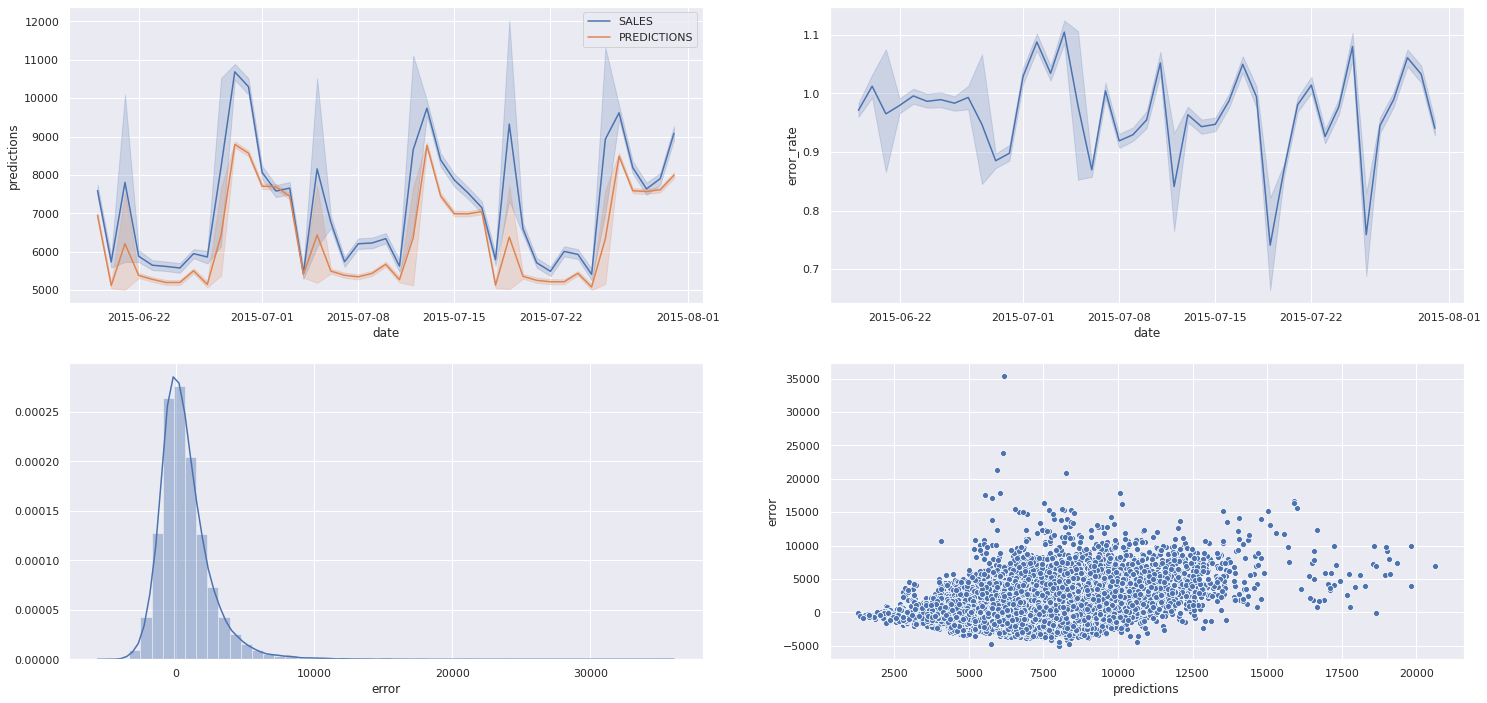

In [79]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.distplot( df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.0 DEPLOY MODEL TO PRODUCTION

In [71]:
pickle.dump(model_xgb_tuned, open('/home/valquiriaam/repos/DS_Producao/model/model_rossmann.pkl', 'wb'))

## 10.3 API Tester

In [72]:
import requests

In [73]:
#loading test data set
df10 = pd.read_csv('/home/valquiriaam/repos/DS_Producao/datasets/test.csv')

df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#Store chosen for prediction
df_test = df_test[df_test['Store'] == 22]

#removed closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [74]:
#Convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [75]:
#API Call

#Deploy in localhost
#url = 'http://0.0.0.0:5000/rossmann/predict'

#Deploy in Heroku
#url = 'https://rossmann-model.herokuapp.com/rossmann/predict'

#Deploy in Render
url = 'https://rossmann-sales-predict-api.onrender.com/rossmann/predict'

header = { 'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print('Status Code {}'.format(r.status_code))


Status Code 200


In [76]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.head(5)


,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,22,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,extended,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,5940.247070
1,22,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,extended,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,6048.928711
2,22,2,2015-09-15T00:00:00.000,1.0,1,regular_day,0,a,extended,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,15,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,5641.381836
3,22,1,2015-09-14T00:00:00.000,1.0,1,regular_day,1,a,extended,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,14,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,7421.537598
4,22,6,2015-09-12T00:00:00.000,1.0,0,regular_day,0,a,extended,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sept,0,2015,9,12,37,2015-36,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,172,3326.313477


In [77]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len(d2) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction']))
    

Store Number 22 will sell R$210,592.11 in the next 6 weeks
